In [27]:
import sys
sys.path.append("/home/benjamin/RewardCurriculum/")

import os
os.system("export MKL_SERVICE_FORCE_INTEL=1")

import gymnasium as gym
from collections import defaultdict
import panda_gym
from stable_baselines3.common.vec_env import DummyVecEnv
import json
import numpy as np
import tqdm

import os
from utils.configs import get_config
from utils.env_wrappers import make_vec_env, get_env
from argparse import Namespace
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [28]:
import matplotlib.font_manager as font_manager

font_dir = ['.']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

In [29]:
def rollout_episodes(env, learner, n_episodes=1, desired_position=None, task=None):
    if task is None:
        weights = np.zeros((1, learner.scheduler.reward_dim))
        weights[:, -1] = 1

    positions = []
    rewards = []
    for _ in range(n_episodes):
        terminated = False
        obs = env.reset()
        if desired_position is not None:
            position = env.get_attr("task")[0].get_goal()
            position[3:] = desired_position
            env.env_method("set_goal", position)
            obs["desired_goal"] = position
        
        if desired_position is not None:
            positions.append(desired_position)
        else:
            positions.append(obs["desired_goal"][:, 3:])
            
        while not terminated:            
            act = learner.predict(obs, weights=weights)[0]
            obs, reward, terminated, info = env.step(act)

        rewards.append(reward)
        
    return rewards, positions

In [30]:
os.chdir("/home/benjamin/RewardCurriculum")
results_dir = "/home/benjamin/RewardCurriculum/results/panda_pick_and_place_obstacle_long_v2"

x_coords = np.arange(-0.15, 0.16, 0.02)
x_dict = {np.round(value, 2): index for index, value in enumerate(x_coords)}
y_coords = np.arange(-0.15, 0.16, 0.02)
y_dict = {np.round(value, 2): index for index, value in enumerate(y_coords)}
z_coords = np.arange(0.02, 0.21, 0.02)
z_dict = {np.round(value, 2): index for index, value in enumerate(z_coords)}

X, Y, Z = np.meshgrid(x_coords, y_coords, z_coords)
desired_positions = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

In [ ]:
generalization_results = defaultdict(list)

for subfolder in tqdm.tqdm(os.listdir(results_dir)):
    folder_path = os.path.join(results_dir, subfolder)
    if not os.path.isdir(folder_path):
        continue
    
    args = Namespace()
    args.env_name = json.load(open(os.path.join(folder_path, "config.json"), "r"))["environment"]["env_name"]
    args.seed = json.load(open(os.path.join(folder_path, "config.json"), "r"))["seed"]
    args.config_path = os.path.join(folder_path, "config_original.json")
    args.continue_from = None

    remaining_args = ["--environment.wrapper_kwargs.0.reward_threshold", "-0.05"]
    
    config = get_config(args.config_path, args, remaining_args)
    config["environment"]["wrappers"] += ["SingleTaskRewardWrapper"]
    config["environment"]["wrapper_kwargs"] += [{}]
    
    make_env_fn = lambda wrappers, wrapper_kwargs, ignore_keyword="ignore" : get_env(config["environment"]["env_name"], wrappers=wrappers, wrapper_kwargs=wrapper_kwargs, ignore_keyword=ignore_keyword)
    env = make_vec_env(make_env_fn, 
                        n_envs=config["environment"]["n_envs"], 
                        env_kwargs={"wrappers": config["environment"]["wrappers"], "wrapper_kwargs": config["environment"]["wrapper_kwargs"]},
                        monitor_kwargs={"allow_early_resets": True},
                        seed=config["seed"], vec_env_cls=DummyVecEnv)
    
    learner = config["learner_class"].load(os.path.join(folder_path, "evaluations", "best_model.zip"), env=env)
    
    cl_type = str(config["learner_kwargs"]["scheduler_class"]).split(" ")[-1][2:-2]
    
    positions = []
    rewards = []
    for position in tqdm.tqdm(desired_positions):
        reward, desired_position = rollout_episodes(env, learner, n_episodes=1, desired_position=position)
        rewards += reward
        positions += desired_position
        
    rewards = np.stack(rewards)
    positions = np.stack(desired_positions)
    
    generalization_results[cl_type].append((rewards, positions))

In [23]:
import pickle
pickle.dump(generalization_results, open(os.path.join(results_dir, "generalization_results.pkl"), "wb"))

In [31]:
import pickle
generalization_results = pickle.load(open(os.path.join(results_dir, "generalization_results.pkl"), "rb"))
generalization_results.keys()

dict_keys(['CurrOT', 'ManualTask', 'SACX', 'SetterSolver', 'Random', 'ALPGMM'])

['Times New Roman']


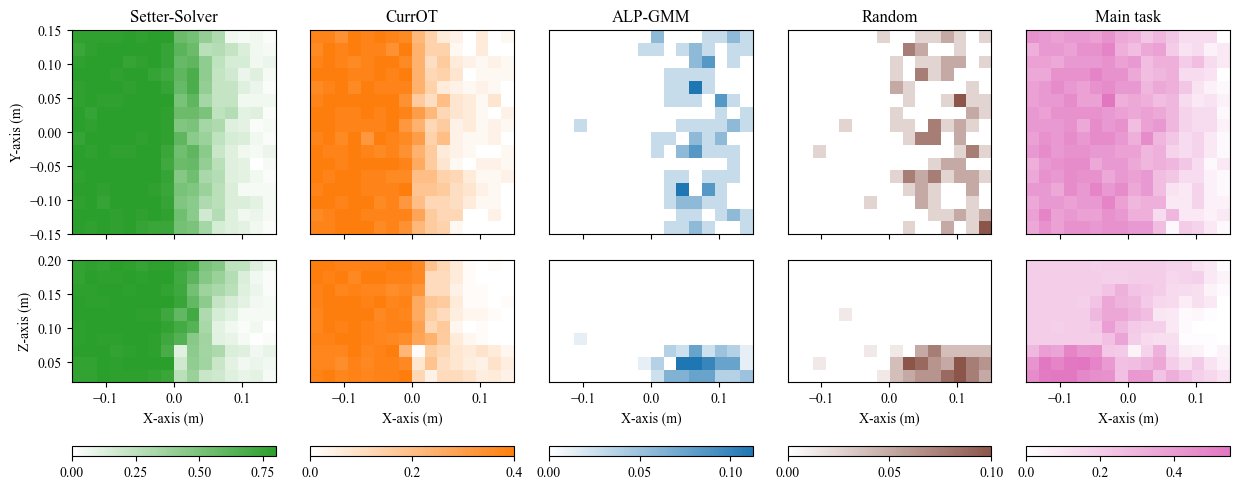

In [32]:
keys_to_plot = ['SetterSolver', 'CurrOT', 'ALPGMM', 'Random', 'ManualTask']
plot_titles = {
    "SetterSolver": "Setter-Solver",
    "CurrOT": "CurrOT", 
    "ALPGMM": "ALP-GMM", 
    "Random": "Random", 
    "ManualTask": "Main task",
    "SACX": "SAC-Q"
}

cmaps = {
    "SetterSolver": LinearSegmentedColormap.from_list("SetterSolver", [(1, 1, 1), (44 / 256, 160 / 256, 44 / 256)], N=128),
    "CurrOT": LinearSegmentedColormap.from_list("CurrOT", [(1, 1, 1), (255 / 256, 127 / 256, 14 / 256)], N=128),
    "ALPGMM": LinearSegmentedColormap.from_list("ALPGMM", [(1, 1, 1), (31 / 256, 119 / 256, 180 / 256)], N=128),
    "Random": LinearSegmentedColormap.from_list("Random", [(1, 1, 1), (140 / 256, 86 / 256, 75 / 256)], N=128),
    "ManualTask": LinearSegmentedColormap.from_list("ManualTask", [(1, 1, 1), (227 / 256, 119 / 256, 194 / 256)], N=128),
    "SACX": LinearSegmentedColormap.from_list("SACX", [(1, 1, 1), (148 / 256, 103 / 256, 189 / 256)], N=128)
}

print(plt.rcParams['font.family'])
plt.rcParams['font.family'] = ['Times New Roman']

fig, axes = plt.subplots(2, len(keys_to_plot), figsize=(2.5 * len(keys_to_plot), 10), sharex=True)
axes = np.reshape(axes, (2, -1))

for idx, cl_algo in enumerate(keys_to_plot):
    reward_data = []
    goal_data = []
    for run in generalization_results[cl_algo]:
        reward_data.append(run[0])
        goal_data.append(run[1])
        
    reward_data = np.concatenate(reward_data, axis=0).reshape(len(reward_data), -1, 1).mean(axis=0)
    goal_data = np.concatenate(goal_data, axis=0).reshape(len(goal_data), -1, 3).mean(axis=0)
    
    unique_positions = np.unique(goal_data[:, :2], axis=0)
    img = np.zeros(X.shape[:2])
    for position in unique_positions:
        mask = (goal_data[:, 0] == position[0]) * (goal_data[:, 1] == position[1])
        img[x_dict[np.round(position[0], 2)], y_dict[np.round(position[1], 2)]] = reward_data[mask].mean()
    
    axes[0, idx].set_title(plot_titles[cl_algo])
    axes[0, idx].imshow(img.T, origin='lower', extent=[-0.15, 0.15, -0.15, 0.15], cmap=cmaps[cl_algo])
    
    unique_positions = np.unique(goal_data[:, [0, 2]], axis=0)
    img = np.zeros((X.shape[0], X.shape[2]))
    for position in unique_positions:
        mask = (goal_data[:, 0] == position[0]) * (goal_data[:, 2] == position[1])
        img[x_dict[np.round(position[0], 2)], z_dict[np.round(position[1], 2)]] = reward_data[mask].mean()
    im = axes[1, idx].imshow(img.T, origin='lower', extent=[-0.15, 0.15, 0.02, 0.2], cmap=cmaps[cl_algo])
    axes[1, idx].set_xlabel("X-axis (m)")
    
    plt.colorbar(im, ax=axes[1, idx], location="bottom")
    
    if idx > 0:
        axes[0, idx].get_yaxis().set_visible(False)
        axes[1, idx].get_yaxis().set_visible(False)
    else:
        axes[0, idx].set_ylabel("Y-axis (m)")
        axes[1, idx].set_ylabel("Z-axis (m)")
    

plt.tight_layout()
plt.subplots_adjust(bottom=0.4, top=0.99, hspace=-0.61, wspace=0.17)
plt.savefig(os.path.join(results_dir, "generalization_results_obstacle.pdf"))
plt.savefig(os.path.join(results_dir, "generalization_results_obstacle.svg"))